# Thermal energy generation for Eastern and North-Eastern regions of India

### Importing libraries and setting figure size and style

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('fivethirtyeight')

### Loading the dataset for Hydro energy generation for Eastern and North-Eastern regions of India

In [2]:
df = pd.read_csv('/Users/devikarajasekar/Documents/SCHOOL/ML PROJ/datasets/eastern-thermal.csv', index_col=0, parse_dates=True)
df = df.asfreq('MS')
df.head()

,ACTUAL
Date,
2020-09-01,16766.82
2020-10-01,17848.23
2020-11-01,15523.88
2020-12-01,17339.33
2021-01-01,18014.61


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2020-09-01 to 2022-08-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ACTUAL  24 non-null     float64
dtypes: float64(1)
memory usage: 384.0 bytes


<AxesSubplot:xlabel='Date'>

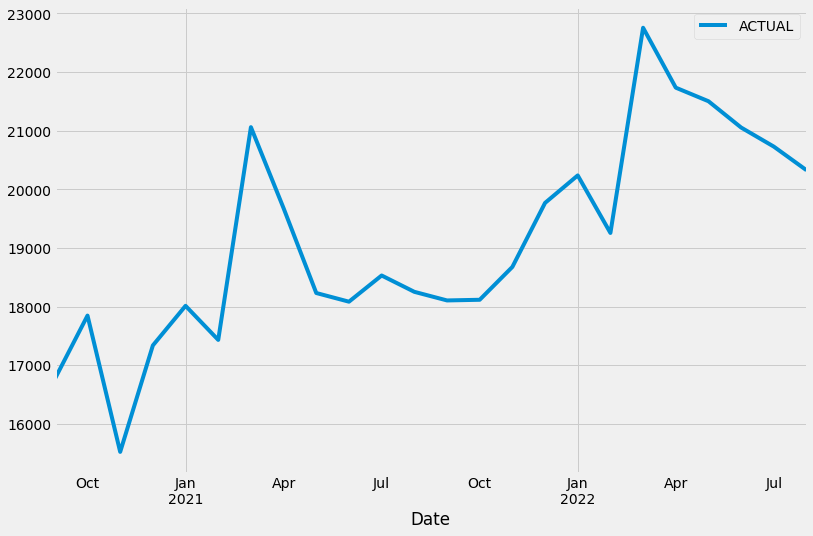

In [4]:
df.plot()

## Exploratory data analysis

### Checking for seasonality

In [5]:
X = df.values

Clearly, there is no seasonality observed in the dataset from the plot.

### Checking for Stationarity

Using **Dickey-Fuller test** since it is a more accurate method.

Sign of obvious trends, seasonality, or other systematic structures in the series are indicators of a non-stationary series.

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.


Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have a time-dependent structure.


We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).


*p-value* > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.


*p-value* <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [9]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.211665
p-value: 0.202039
Critical Values:
	1%: -3.753
	5%: -2.998
	10%: -2.639


Hence, this data is non-stationary.

Performing log-transformation of data to convert non-stationary data to stationary data

In [10]:
X = np.log(X)
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.244232
p-value: 0.190585
	1%: -3.753
	5%: -2.998
	10%: -2.639


Data is still non-stationary.

#### Transforming non-stationary series to make it stationary

Using differencing (involves taking the differences of consecutive observations)

In [11]:
Xd = df.diff(periods=1)
Xd

,ACTUAL
Date,
2020-09-01,NaN
2020-10-01,1081.41
2020-11-01,-2324.35
2020-12-01,1815.45
2021-01-01,675.28
2021-02-01,-580.83
2021-03-01,3627.70
2021-04-01,-1382.75
2021-05-01,-1445.53


In [12]:
Xd = Xd.dropna()

In [13]:
results = adfuller(Xd)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.244232
p-value: 0.190585
Critical Values:
	1%: -3.753
	5%: -2.998
	10%: -2.639


Now, the data is stationary since p-value<0.05

### Autocorrelation analysis

Using Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots to decide whether some data is best suited to an MA model or an AR model.

Selecting the right model order is of great importance to predictions.

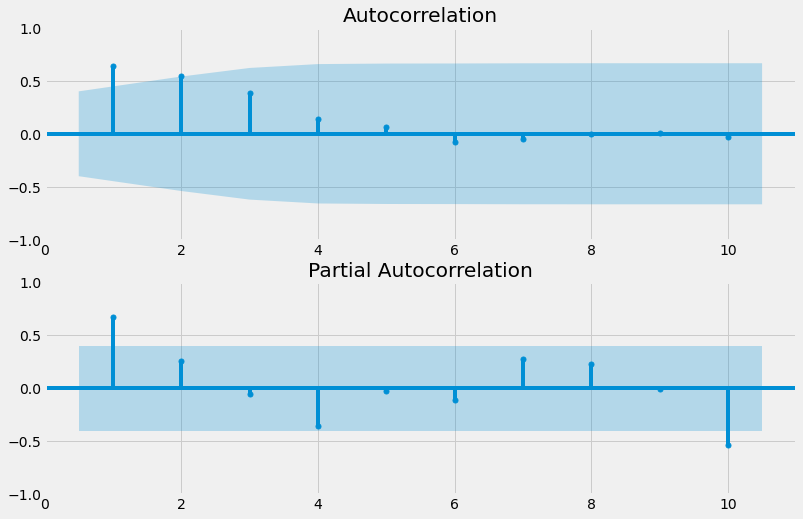

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))

# Plot the ACF of df
plot_acf(df, lags=10, zero=False, ax=ax1);

# Plot the PACF of df
plot_pacf(df, lags=10, zero=False, ax=ax2);

#### Interpretation of the plots

Blue area depicts the 95% confidence interval and is an indicator of the significance threshold. That means, anything within the blue area is statistically close to zero and anything outside the blue area is statistically non-zero.

There are several autocorrelations that are significantly non-zero. Therefore, the time series is non-random.

**Strong correlation at a lag of 1 in PACF plot**
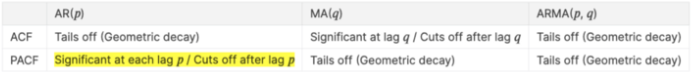

Hence, we try AR(p=1) model

## Implementing AutoRegression models

### Implementing Auto Regressive model with p = 1

In [49]:
from statsmodels.tsa.ar_model import AutoReg
ar_model = AutoReg(df['ACTUAL'], lags = 7).fit()
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                 ACTUAL   No. Observations:                   24
Model:                     AutoReg(7)   Log Likelihood                -141.014
Method:               Conditional MLE   S.D. of innovations            968.742
Date:                Wed, 02 Nov 2022   AIC                            300.028
Time:                        12:43:07   BIC                            307.527
Sample:                    04-01-2021   HQIC                           300.773
                         - 08-01-2022                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2519.9862   5052.680      0.499      0.618   -7383.085    1.24e+04
ACTUAL.L1      0.5721      0.202      2.838      0.005       0.177       0.967
ACTUAL.L2      0.1071      0.223      0.481      0.631      -0.330       0.544
ACTUAL.L3      0.1300      0.227      0.573      0.567      -0.315       0.575
ACTUAL.L4      0.0128      0.222      0.058      0.954      -0.423       0.449
ACTUAL.L5     -0.0887      0.201     -0.441      0.660      -0.483       0.306
ACTUAL.L6      0.0675      0.237      0.285      0.776      -0.397       0.532
ACTUAL.L7      0.0789      0.225      0.351      0.725      -0.361       0.519
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0631           -0.0000j            1.0631           -0.0000
AR.2            1.0473           -0.9482j            1.4128           -0.1171
AR.3            1.0473           +0.9482j            1.4128            0.1171
AR.4           -0.3424           -1.3339j            1.3771           -0.2900
AR.5           -0.3424           +1.3339j            1.3771            0.2900
AR.6           -1.6641           -0.6165j            1.7746           -0.4435
AR.7           -1.6641           +0.6165j            1.7746            0.4435
-----------------------------------------------------------------------------
"""

In [50]:
# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(ar_model.resid))
# Print mean absolute error
print(mae)

670.2282775707599


### Autocorrelation analysis with Stationary data

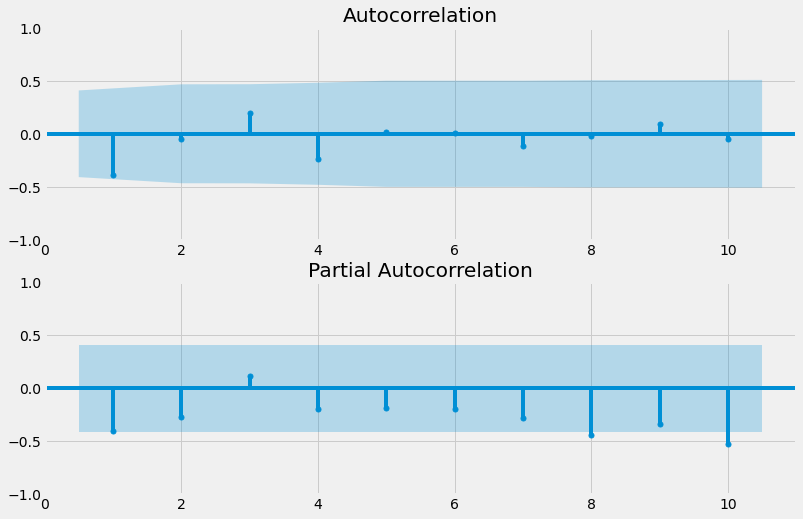

In [51]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))

# Plot the ACF of df
plot_acf(Xd.dropna(), lags=10, zero=False, ax=ax1);

# Plot the PACF of df
plot_pacf(Xd.dropna(), lags=10, zero=False, ax=ax2);

#### Interpretation of the plots

Blue area depicts the 95% confidence interval and is an indicator of the significance threshold. That means, anything within the blue area is statistically close to zero and anything outside the blue area is statistically non-zero.

There are several autocorrelations that are significantly non-zero. Therefore, the time series is non-random.

High degree of autocorrelation between adjacent (lag = 1) in PACF plot
Geometric decay in ACF plot

Based on the above table, we can use an AR(1) model to model this process.
With AR(p=1), the formula


can be rewritten to the following:



In [52]:
from statsmodels.tsa.ar_model import AutoReg
ar_model = AutoReg(Xd[['ACTUAL']], lags = 1).fit()
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                 ACTUAL   No. Observations:                   23
Model:                     AutoReg(1)   Log Likelihood                -188.753
Method:               Conditional MLE   S.D. of innovations           1287.874
Date:                Wed, 02 Nov 2022   AIC                            383.506
Time:                        12:43:49   BIC                            386.779
Sample:                    11-01-2020   HQIC                           384.277
                         - 08-01-2022                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        183.1617    276.806      0.662      0.508    -359.368     725.691
ACTUAL.L1     -0.3914      0.195     -2.010      0.044      -0.773      -0.010
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.5552           +0.0000j            2.5552            0.5000
-----------------------------------------------------------------------------
"""

In [53]:
# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(ar_model.resid))
# Print mean absolute error
print(mae)

969.7037527929532


Since the error is high, other models are explored.

## SARIMA models

## SARIMAX model

SARIMAX(Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors) is an updated version of the ARIMA model. we can say SARIMAX is a seasonal equivalent model like SARIMA and Auto ARIMA. it can also deal with external effects. This feature of the model differs from other models.

#### Seasonal Decomposition

Time series can be composed of trend, seasonal and residual components.

Seasonal data
- Has predictable and repeated patterns
- Repeats after any amount of time

Seasonal decomposition
- time series = trend + seasonal + residual

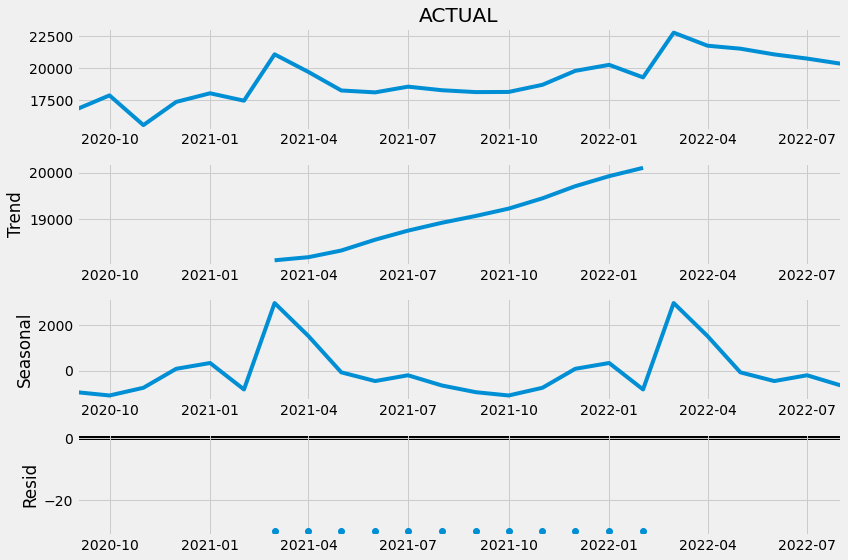

In [54]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform additive decomposition
decomp = seasonal_decompose(df['ACTUAL'], period=12)

# Plot decomposition
decomp.plot();
plt.tight_layout();

Seasonal ARIMA = SARIMA

SARIMA(p,d,q)(P,D,Q)_s 

**Non-seasonal orders**

p: autoregressive order

d: differencing order

q: moving average order


**Seasonal orders**

P: seasonal autoregressive order

D: seasonal differencing order

Q: seasonal moving average order

S: Number of time steps per cycle

#### Differencing and fitting ARMA

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [55]:
data_diff = df.diff().dropna()

# Creating a simple ARMA(1,1,0) model 
arma = SARIMAX(data_diff, order=(1,1,0))

# Fit model
arma_results = arma.fit(disp=0)

# Print fit summary
print(arma_results.summary())

                               SARIMAX Results                                
Dep. Variable:                 ACTUAL   No. Observations:                   23
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -196.503
Date:                Wed, 02 Nov 2022   AIC                            397.007
Time:                        12:44:45   BIC                            399.189
Sample:                    10-01-2020   HQIC                           397.521
                         - 08-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6294      0.123     -5.120      0.000      -0.870      -0.388
sigma2      3.142e+06   1.09e+06      2.879      0.004       1e+06    5.28e+06
Ljung-Box (L1) (Q):                   2.69   Jarque-

Unrolling ARMA forecast

In [56]:
arma_diff_forecast = arma_results.get_forecast(steps=5).predicted_mean

# Integrate the difference forecast
arma_int_forecast = np.cumsum(arma_diff_forecast)

# Make absolute value forecast
arma_value_forecast = arma_int_forecast + df.iloc[-1, 0]

# Print forecast
print("PREDICTIONS FOR NEXT 5 MONTHS: ")
print(arma_value_forecast)

PREDICTIONS FOR NEXT 5 MONTHS: 
2022-09-01    19972.955672
2022-10-01    19588.256009
2022-11-01    19222.939886
2022-12-01    18845.423161
2023-01-01    18475.585873
Freq: MS, Name: predicted_mean, dtype: float64


In [57]:
# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(arma_results.resid))

# Print mean absolute error
print(mae)

1443.7528294211659


#### Fitting an ARIMA model using statsmodels instead of modeling the difference and then integrating

In [58]:
arima = SARIMAX(df, order=(1,0,1))

# Fit ARIMA model
arima_results = arima.fit(disp=0)

# Make ARIMA forecast of next 5 values
arima_value_forecast = arima_results.get_forecast(steps=5).predicted_mean

# Print forecast
print("PREDICTIONS FOR NEXT 5 MONTHS: ")
print(arima_value_forecast)

PREDICTIONS FOR NEXT 5 MONTHS: 
2022-09-01    20552.573862
2022-10-01    20536.217235
2022-11-01    20519.873626
2022-12-01    20503.543023
2023-01-01    20487.225417
Freq: MS, Name: predicted_mean, dtype: float64


In [59]:
# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(arima_results.resid))

# Print mean absolute error
print("MAE: ",mae)

MAE:  1551.8001297559613


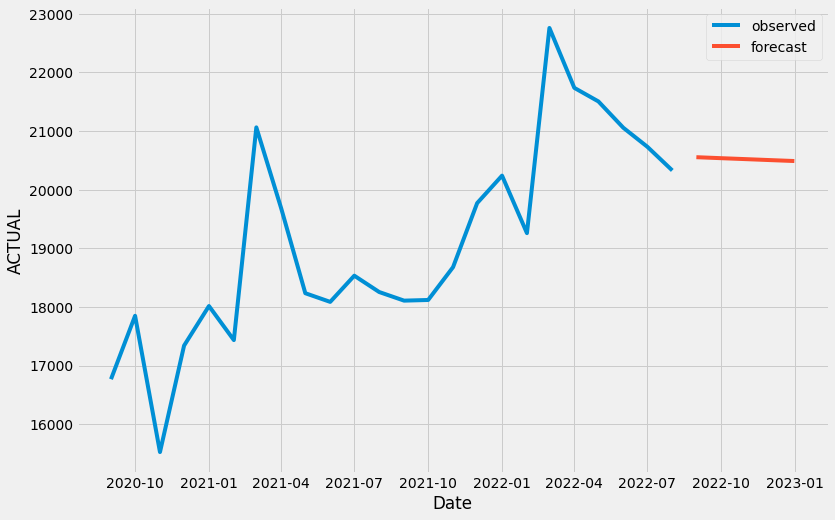

In [75]:
plt.plot(df.index[-24:], df.iloc[-24:]['ACTUAL'], label='observed');

# Plot your mean forecast
rng = pd.date_range(start='2022-08-01', end='2023-01-01',freq='M')
plt.plot(rng, arima_value_forecast.values, label='forecast');

# set labels, legends
plt.xlabel('Date');
plt.ylabel('ACTUAL');
plt.legend();


## Evaluating ARIMA model parameters

In [61]:
X = df['ACTUAL']
X.head()

Date
2020-09-01    16766.82
2020-10-01    17848.23
2020-11-01    15523.88
2020-12-01    17339.33
2021-01-01    18014.61
Freq: MS, Name: ACTUAL, dtype: float64

In [62]:
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [63]:
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA model: %s MSE=%.3f' % (best_cfg, best_score))

In [64]:
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)

evaluate_models(df.values, p_values, d_values, q_values)

Best ARIMA model: None MSE=inf


## Automated SARIMA model selection

### Using pmdarima package

Automatically discover the optimal order for an ARIMA model.

The auto-ARIMA process seeks to identify the most optimal
parameters for an ARIMA model, settling on a single fitted ARIMA model. 

In [32]:
# !pip install pmdarima

In [65]:
import pmdarima as pm

# Create auto_arima model
model1 = pm.auto_arima(df,
                      seasonal=True, 
                      m=12,  # period for seasonal differencing
                      D=1,  #order of seasonal differencing
                      trace=True,   #print status on the fits
                      error_action='ignore',
                      suppress_warnings=True)

# Print model summary
print(model1.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=1.05 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=198.256, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=201.920, Time=0.13 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=221.506, Time=0.03 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=200.254, Time=0.05 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=200.253, Time=0.04 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=201.888, Time=0.36 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=200.967, Time=0.04 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.26 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 2.306 seconds
                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                   24
Model: 

Using AIC (Akaike Information Criterion), best SARIMA model is chosen

Lower AIC indicates a better model

AIC likes to choose simple models with lower order

## SARIMA vs ARIMA forecasts

In [69]:
model = SARIMAX(df, order=(0,1,2), enforce_stationarity=True, enforce_invertibility=True)

arima_results = model.fit(disp=0)
print(arima_results.summary())


                               SARIMAX Results                                
Dep. Variable:                 ACTUAL   No. Observations:                   24
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -197.983
Date:                Wed, 02 Nov 2022   AIC                            401.967
Time:                        12:46:42   BIC                            405.373
Sample:                    09-01-2020   HQIC                           402.824
                         - 08-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0038      0.150      0.025      0.980      -0.290       0.297
ma.L2         -0.1589      0.229     -0.693      0.488      -0.608       0.291
sigma2      1.778e+06   4.01e+05      4.435      0.0

In [70]:
arima_pred = arima_results.get_forecast(24)
arima_mean = arima_pred.predicted_mean

In [71]:
#calcuate the mean squared error of the model
rmse = math.sqrt(mean_squared_error(df.values, arima_mean))
#Calculate the mean absolute error of the model 
mae = mean_absolute_error(df.values, arima_mean)

print("RMSE: ",rmse)
print("MAE: ",mae)

RMSE:  2170.639776011078
MAE:  1830.2506446326424


In [72]:
model = SARIMAX(df, order=(0,0,0), seasonal_order=(0,1,0,12), 
                enforce_stationarity=True, enforce_invertibility=True)

sarima_results = model.fit(disp=0)
# ARIMA(0,0,0)(0,1,0)[12]

In [73]:
# Getting Out-of-sample SARIMA mean forecasts
sarima_pred = sarima_results.get_forecast(24)
sarima_mean = sarima_pred.predicted_mean

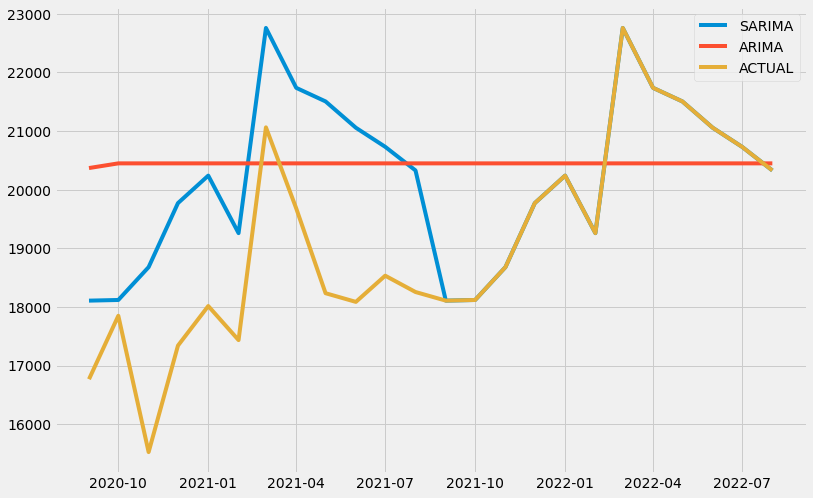

In [74]:
dates = df.index
# Plot mean ARIMA and SARIMA predictions and observed
plt.plot(dates, sarima_mean, label='SARIMA');
plt.plot(dates, arima_mean, label='ARIMA');
plt.plot(df, label='ACTUAL');
plt.legend();

### Evaluating the models

#### Plot diagnostics

**Test vs Good fit**

Standardized residual: There are no obvious patterns in the residuals

Histogram plus kde estimate:	The KDE curve should be very similar to the normal distribution

Normal Q-Q:	Most of the data points should lie on the straight line

Correlogram:	95% of correlations for lag greater than one should not be significant

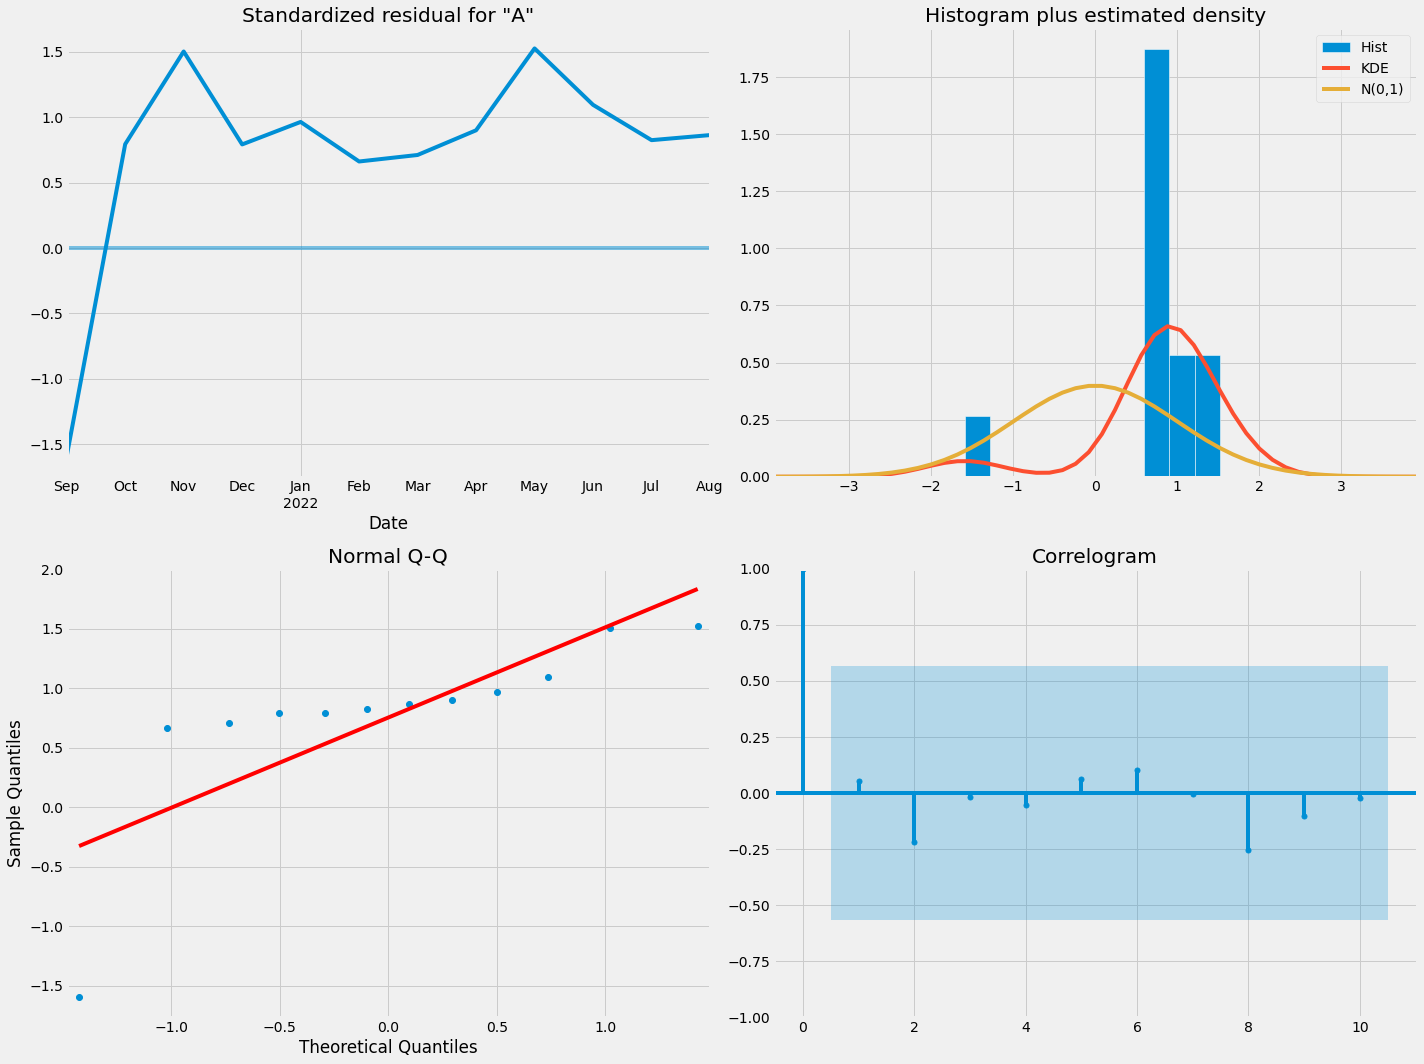

In [40]:
sarima_results.plot_diagnostics(figsize=(20, 15));
plt.tight_layout();

#### Statistical diagnostics

In [79]:
#calcuate the mean squared error of the model
rmse = math.sqrt(mean_squared_error(df.values, sarima_mean))
#Calculate the mean absolute error of the model 
mae = mean_absolute_error(df.values, sarima_mean)

print("RMSE: ",rmse)
print("MAE: ",mae)

RMSE:  1603.873046389063
MAE:  1062.6541666666667


### Future forecast

#### One-step prediction

In [80]:
one_step_forecast = sarima_results.get_prediction(start=-10)

# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = one_step_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower ACTUAL']
upper_limits = confidence_intervals.loc[:,'upper ACTUAL']

# Print best estimate  predictions
print(mean_forecast.values)

[15523.88 17339.33 18014.61 17433.78 21061.48 19678.73 18233.2  18085.25
 18531.93 18253.49]


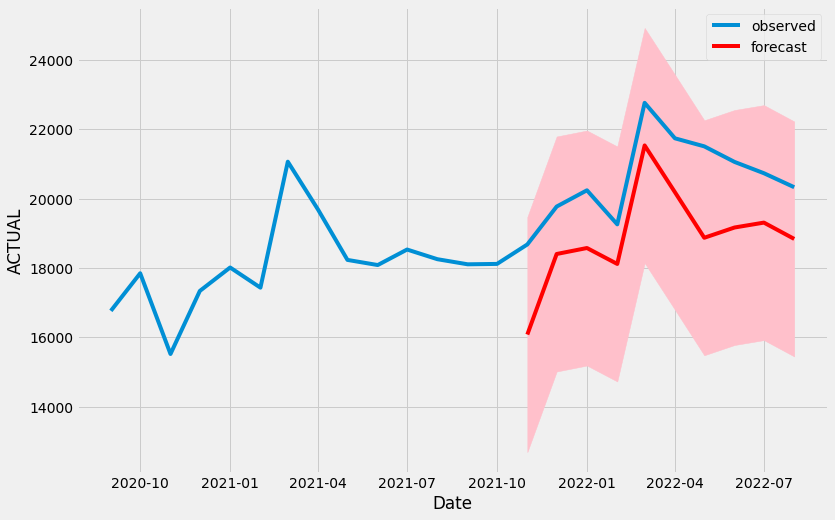

In [43]:
plt.plot(df.index, df['ACTUAL'], label='observed');

# Plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast');

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink');

# Set labels, legends
plt.xlabel('Date');
plt.ylabel('ACTUAL');
plt.legend();

#### Generating dynamic predictions

In [81]:
dynamic_forecast = sarima_results.get_prediction(start=-10, dynamic=True)

# Extract prediction mean
dmean_forecast = dynamic_forecast.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = dynamic_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:, 'lower ACTUAL']
upper_limits = confidence_intervals.loc[:, 'upper ACTUAL']

# Print predictions
print(dmean_forecast.values)

[15523.88 17339.33 18014.61 17433.78 21061.48 19678.73 18233.2  18085.25
 18531.93 18253.49]


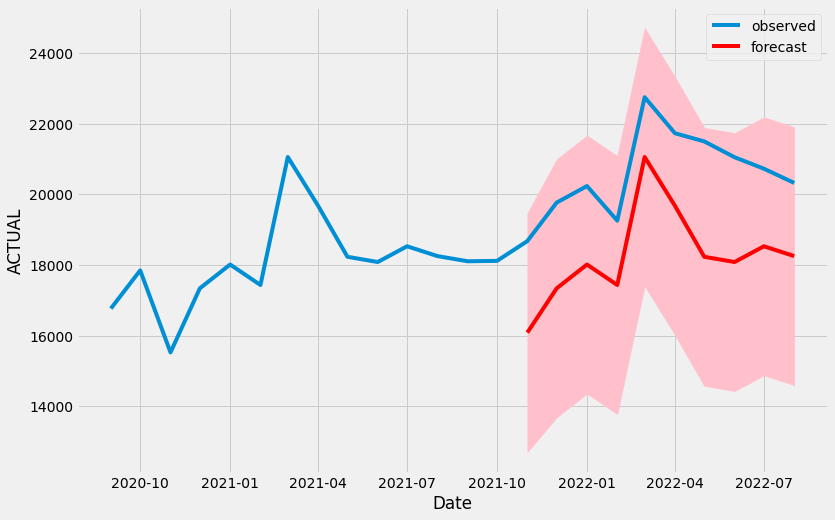

In [45]:
plt.plot(df.index, df['ACTUAL'], label='observed');

# Plot your mean predictions
plt.plot(dmean_forecast.index, dmean_forecast, color='r', label='forecast');

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink');

# Set labels, legends
plt.xlabel('Date');
plt.ylabel('ACTUAL');
plt.legend();

Making dynamic predictions, means that the model makes predictions with no corrections, unlike the one-step-ahead predictions. It is like making a forecast now for the next 5 months, and then waiting to see what happens before comparing how good the predictions were.

## Future forecasting

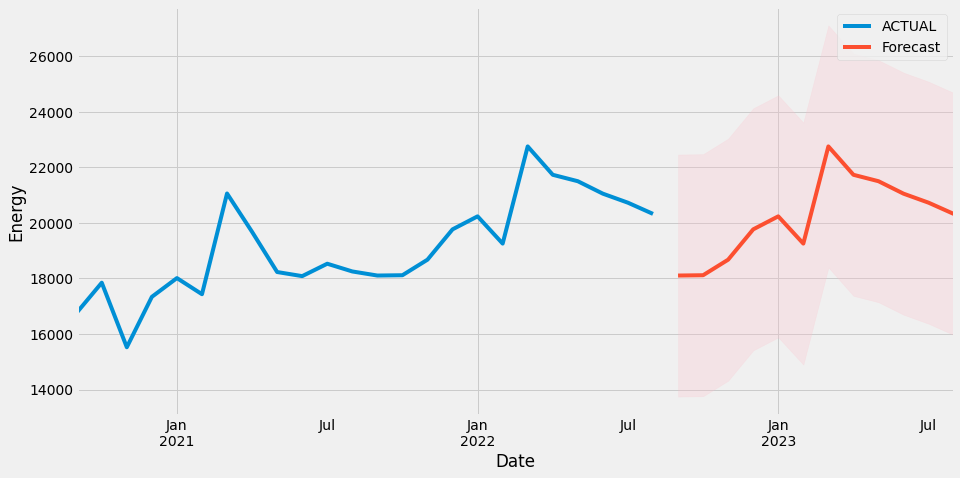

In [82]:
# Forecast 1y
pred_uc = sarima_results.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()
ax = df.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='pink', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Energy')
plt.legend()
plt.show()

### Predicted energy values for the next year

In [83]:
pred_uc.predicted_mean

2022-09-01    18106.55
2022-10-01    18117.85
2022-11-01    18678.13
2022-12-01    19769.62
2023-01-01    20238.38
2023-02-01    19257.46
2023-03-01    22756.63
2023-04-01    21734.98
2023-05-01    21503.49
2023-06-01    21054.79
2023-07-01    20729.69
2023-08-01    20326.86
Freq: MS, Name: predicted_mean, dtype: float64